In [3]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn import metrics

from sklearn.model_selection import KFold

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, scale
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans

from yellowbrick.classifier import ClassificationReport

from sklearn.model_selection import train_test_split

In [8]:
data = pd.read_csv("./data/wrangled_injury_withcounties_Mark.csv", encoding = 'cp850', dtype = 'unicode', 
                   usecols=["UPA", "EventDate", "State", "NAMELSAD", "Month", "Year", "InsideUS", "Event","Source","Primary NA","BodyPart", "Part_of _1", "Nature", "Amputation", "Hospitaliz"])

data = data.fillna(0)

pd.set_option('display.max_columns',None)
data['EventDate'] = data['EventDate'].astype('datetime64')
data['Month'] = pd.DatetimeIndex(data['EventDate']).month
data['Day'] = pd.DatetimeIndex(data['EventDate']).day
data['Year'] = pd.DatetimeIndex(data['EventDate']).year
data.InsideUS = data.InsideUS.astype("int64")
data.Hospitaliz = data.Hospitaliz.astype("int64")
data.Amputation = data.Amputation.astype("int64")
data.Nature = data.Nature.astype("int64")
data.Event = data.Event.astype("int64")
data.Source = data.Source.astype("int64")
data.BodyPart = data.BodyPart.astype("int64")
data.NAMELSAD = data.NAMELSAD.astype("str")
data['Primary NA'] = data['Primary NA'].astype('int64')

ValueError: invalid literal for int() with base 10: '48-49'

In [9]:
data.loc[data['Primary NA'] == '48-49']

,UPA,EventDate,State,Primary NA,Hospitaliz,Amputation,Nature,BodyPart,Part_of _1,Event,Source,NAMELSAD,Month,Year,InsideUS,Day
39278,1180232,2017-02-05,FLORIDA,48-49,1,1,1311,4422,Fingertip(s),60,9999,Hillsborough County,2,2017,1,5


In [10]:
data = data.drop(39278, axis=0)
data['Primary NA'] = data['Primary NA'].astype('int64')

In [11]:
data["Amputation"].value_counts()

0    29203
1    10603
2       23
3        3
9        1
4        1
Name: Amputation, dtype: int64

In [12]:
data["Hospitaliz"].value_counts()

1    31725
0     7861
2      242
3        5
5        1
Name: Hospitaliz, dtype: int64

In [13]:
data = data[(data["Hospitaliz"] == 0)|(data["Hospitaliz"] == 1)]
data = data[(data["Amputation"] == 0)|(data["Amputation"] == 1)]

In [14]:
data["InsideUS"].value_counts()

1    39504
0       58
Name: InsideUS, dtype: int64

In [15]:
data.drop(data[data['InsideUS'] < 1].index, inplace = True)

In [16]:
data["InsideUS"].value_counts()

1    39504
Name: InsideUS, dtype: int64

In [17]:
data.head(5)

,UPA,EventDate,State,Primary NA,Hospitaliz,Amputation,Nature,BodyPart,Part_of _1,Event,Source,NAMELSAD,Month,Year,InsideUS,Day
1,1228909,2017-06-15,NEBRASKA,311119,0,1,1311,4429,"Finger(s), fingernail(s), n.e.c.",6412,3714,Cuming County,6,2017,1,15
2,1238273,2017-06-24,NEBRASKA,311512,0,1,1311,4422,Fingertip(s),6411,3421,Cuming County,6,2017,1,24
3,1384150,2018-09-17,NEBRASKA,311512,1,0,1729,6,BODY SYSTEMS,531,9262,Cuming County,9,2018,1,17
4,930752,2015-01-06,NEBRASKA,236220,1,0,111,52,Ankle(s),40,660,Lancaster County,1,2015,1,6
5,933523,2015-01-20,NEBRASKA,331511,1,0,111,510,"Leg(s), unspecified",6260,3460,Lancaster County,1,2015,1,20


In [15]:
data.describe()

,Primary NA,Hospitaliz,Amputation,Nature,BodyPart,Event,Source,Month,Year,InsideUS,Day
count,39504.000000,39504.000000,39504.000000,39504.000000,39504.000000,39504.000000,39504.000000,39504.000000,39504.000000,39504.0,39504.000000
mean,394686.489824,0.801615,0.267745,862.607306,2159.533490,3899.191069,4835.788123,6.301818,2016.489393,1.0,15.675856
std,159963.559763,0.398789,0.442790,766.101911,2658.374362,2504.936810,2929.099736,3.278137,1.103595,0.0,8.682277
min,0.000000,0.000000,0.000000,7.000000,6.000000,20.000000,10.000000,1.000000,2015.000000,1.0,1.000000
25%,311313.000000,1.000000,0.000000,111.000000,320.000000,642.000000,3222.000000,3.000000,2016.000000,1.0,8.000000
50%,333120.000000,1.000000,0.000000,1311.000000,512.000000,4330.000000,4211.000000,6.000000,2016.000000,1.0,16.000000
75%,491110.000000,1.000000,1.000000,1311.000000,4422.000000,6252.000000,7173.000000,9.000000,2017.000000,1.0,23.000000
max,999999.000000,1.000000,1.000000,9999.000000,9999.000000,9999.000000,9999.000000,12.000000,2018.000000,1.0,31.000000


In [16]:
data.drop('InsideUS', axis=1)

,UPA,EventDate,State,Primary NA,Hospitaliz,Amputation,Nature,BodyPart,Part_of _1,Event,Source,NAMELSAD,Month,Year,Day
1,1228909,2017-06-15,NEBRASKA,311119,0,1,1311,4429,"Finger(s), fingernail(s), n.e.c.",6412,3714,Cuming County,6,2017,15
2,1238273,2017-06-24,NEBRASKA,311512,0,1,1311,4422,Fingertip(s),6411,3421,Cuming County,6,2017,24
3,1384150,2018-09-17,NEBRASKA,311512,1,0,1729,6,BODY SYSTEMS,531,9262,Cuming County,9,2018,17
4,930752,2015-01-06,NEBRASKA,236220,1,0,111,52,Ankle(s),40,660,Lancaster County,1,2015,6
5,933523,2015-01-20,NEBRASKA,331511,1,0,111,510,"Leg(s), unspecified",6260,3460,Lancaster County,1,2015,20
6,946968,2015-02-04,NEBRASKA,623110,1,0,160,111,Brain,422,6650,Lancaster County,2,2015,4
7,947069,2015-02-05,NEBRASKA,237110,1,0,111,510,"Leg(s), unspecified",429,6630,Lancaster County,2,2015,5
8,962317,2015-02-07,NEBRASKA,561920,1,0,1972,341,Hip(s),422,6620,Lancaster County,2,2015,7
9,964870,2015-02-24,NEBRASKA,238190,1,0,10,9999,Nonclassifiable,4333,9999,Lancaster County,2,2015,24
10,964805,2015-02-25,NEBRASKA,238210,1,0,1972,423,Forearm(s),620,7352,Lancaster County,2,2015,25


In [17]:
data.dropna(how="any", inplace=True)

In [18]:
data["NAMELSAD"].isna().sum()

0

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39504 entries, 1 to 39833
Data columns (total 16 columns):
UPA           39504 non-null object
EventDate     39504 non-null datetime64[ns]
State         39504 non-null object
Primary NA    39504 non-null int64
Hospitaliz    39504 non-null int64
Amputation    39504 non-null int64
Nature        39504 non-null int64
BodyPart      39504 non-null int64
Part_of _1    39504 non-null object
Event         39504 non-null int64
Source        39504 non-null int64
NAMELSAD      39504 non-null object
Month         39504 non-null int64
Year          39504 non-null int64
InsideUS      39504 non-null int64
Day           39504 non-null int64
dtypes: datetime64[ns](1), int64(11), object(4)
memory usage: 5.1+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D69723710>,
      dtype=object)

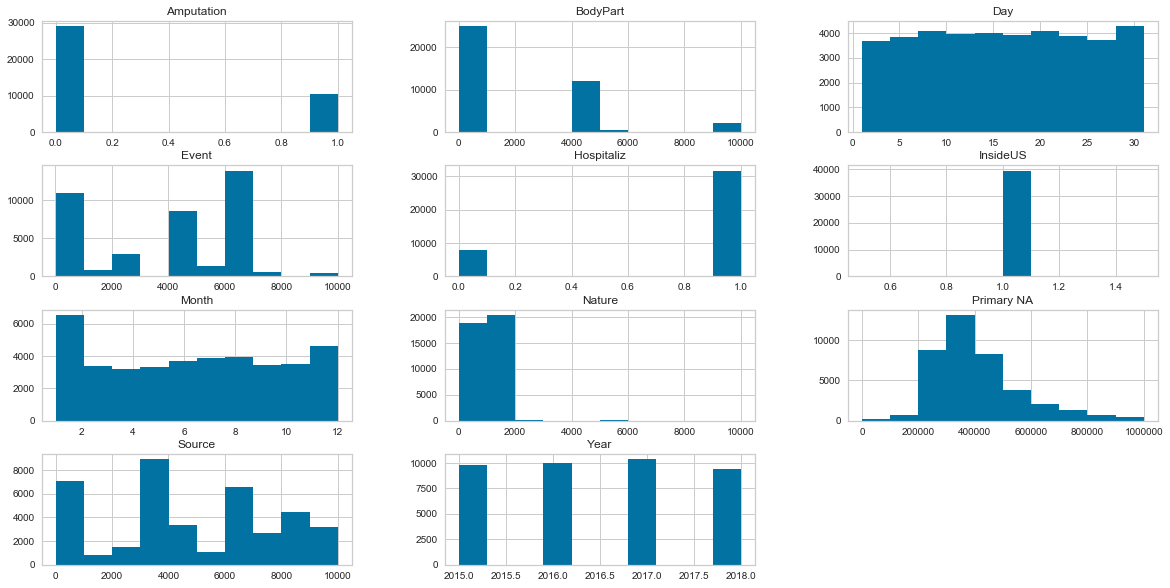

In [20]:
data.hist(figsize=(20,10))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

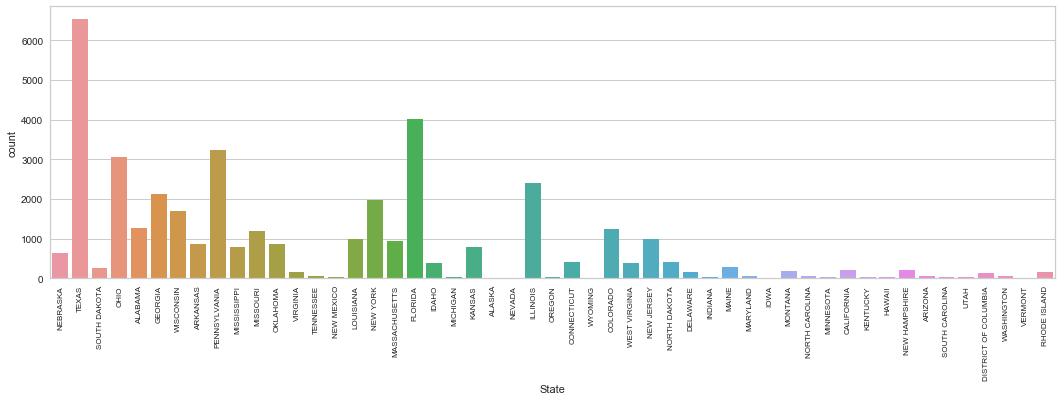

In [21]:
categorical_attributes = data.select_dtypes(include=['object'])

plt.figure(figsize=[18,5])
sns.countplot(data = categorical_attributes, x = 'State')
plt.xticks(rotation=90, fontsize=8)

In [22]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['State'] = le.fit_transform(data.State.values)

data['NAMELSAD'] = le.fit_transform(data.NAMELSAD.values)

In [18]:
features = ["State","Source","BodyPart","Nature","NAMELSAD","Amputation","Month","Primary NA","Event"]
target = ["Hospitaliz"]

X = data[features]
y = data[target]

features2 = ["State","Source","BodyPart","Nature","NAMELSAD",'Hospitaliz',"Month","Primary NA","Event"]
target2= ["Amputation"]

X2 = data[features2]
y2 = data[target2]

features3 =["State","Source","BodyPart","Nature","NAMELSAD",'Hospitaliz','Amputation',"Month","Primary NA","Event"] 
X3 = data[features3]

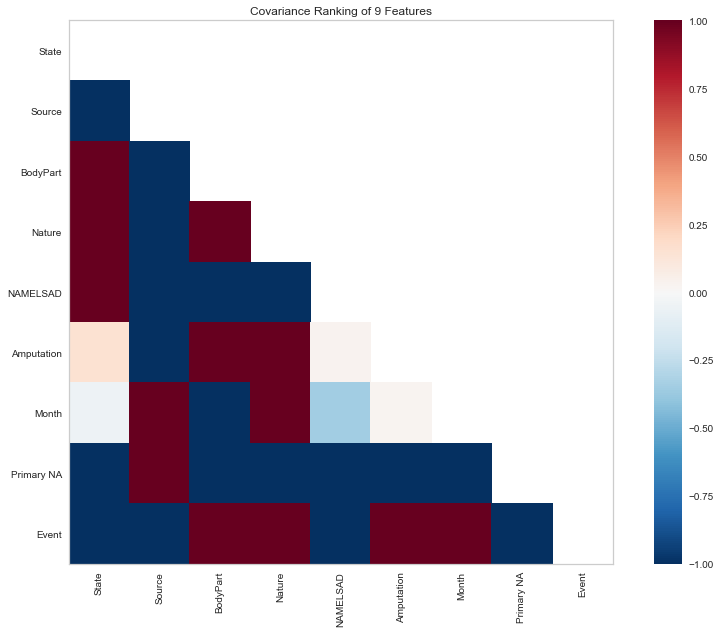

In [24]:
visualizer = Rank2D(algorithm="covariance", size=(1080, 720))
visualizer.fit_transform(X)
visualizer.poof()

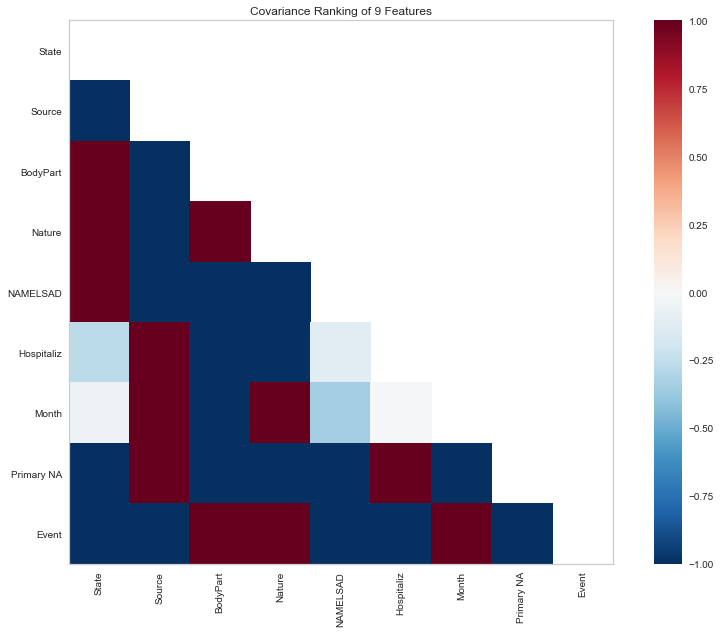

In [25]:
visualizer = Rank2D(algorithm="covariance", size=(1080, 720))
visualizer.fit_transform(X2)
visualizer.poof()

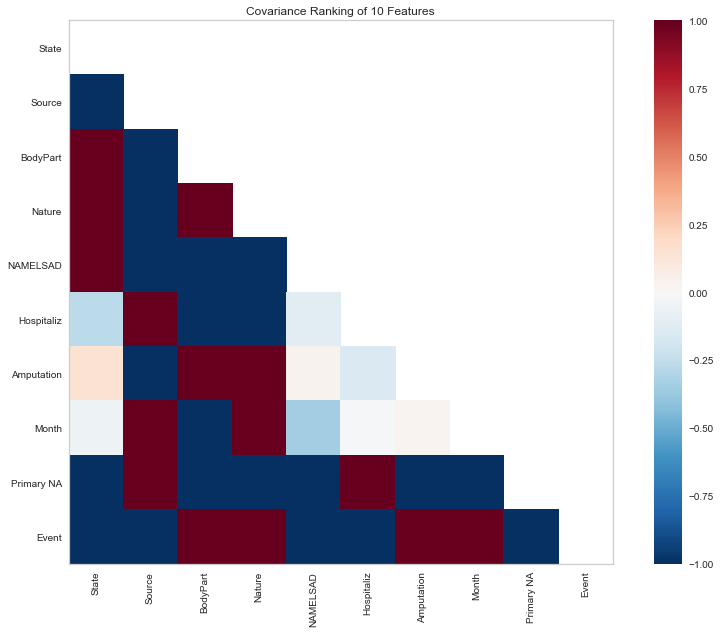

In [26]:
visualizer = Rank2D(algorithm="covariance", size=(1080, 720))
visualizer.fit_transform(X3)
visualizer.poof()

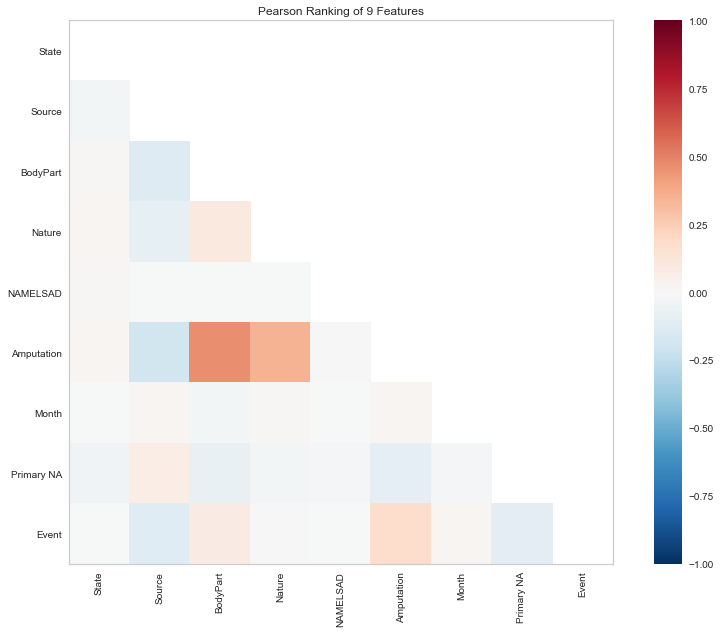

In [27]:
visualizer = Rank2D(algorithm="pearson", size=(1080, 720))
visualizer.fit_transform(X)
visualizer.poof()

In [28]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [37]:
# Try them all!

models = [
    SVC(gamma='auto'), LinearSVC(), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

features = [X,X2]

for model in models:
    for feature in features:
        if feature is X:
            score_model(feature, y, model)
        else:
            score_model(feature, y2, model)

SVC: 0.9531636795722348
SVC: 0.983824569676963
LinearSVC: 0.9698517483416053
LinearSVC: 0.9933980948788078
SGDClassifier: 0.9613315345480552
SGDClassifier: 0.987514081862561
KNeighborsClassifier: 0.9623934103841255
KNeighborsClassifier: 0.9816440542697527
LogisticRegression: 0.9648340282491353
LogisticRegression: 0.9875916525662718
LogisticRegressionCV: 0.9568174757599046
LogisticRegressionCV: 0.9865538316878232
BaggingClassifier: 0.9938075579549063
BaggingClassifier: 0.9979673835972583
ExtraTreesClassifier: 0.9999684203877977
ExtraTreesClassifier: 1.0
RandomForestClassifier: 0.999968421385038
RandomForestClassifier: 0.9999527253817425


In [ ]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['No', 'Yes'], 
        cmap='PRGn', size=(600, 360)
    )
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()  

for model in models:
    visualize_model(X, y, model)

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabaz', timings=False
)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [ ]:
# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(10)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [ ]:
model = KMeans(8)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)
visualizer.poof()

In [ ]:
k = 10
cluster = KMeans(init='k-means++', n_clusters=k, n_init=12)
cluster.fit(X)
metrics.silhouette_score(X, cluster.labels_)

In [ ]:
k = 7
cluster = KMeans(init='k-means++', n_clusters=k, n_init=12)
cluster.fit(X)
metrics.silhouette_score(X, cluster.labels_)

In [ ]:
k = 4
cluster = KMeans(init='k-means++', n_clusters=k, n_init=12)
cluster.fit(X)
metrics.silhouette_score(X, cluster.labels_)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

# adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
range_n_clusters = range(8,11)
List1 = []
List2 = []
List3 = []
 
for n_clusters in range_n_clusters:
    def bench_clustering(estimator, name, data):
        estimator.fit(data)
        v1 = name 
        v2 = n_clusters
        v3 = metrics.silhouette_score(data, estimator.labels_)

        List1.append(v1)
        List2.append(v2)
        List3.append(v3)

    bench_clustering(KMeans(init='k-means++', n_clusters=n_clusters, n_init=12),
                  name="K-Means", data=X)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bench_clustering(MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, n_init=12,max_no_improvement=10, verbose=0,random_state=0),
                     name="MiniBatchKMeans", data=X)
    bench_clustering(AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
                  name="Ward", data=X)   

    bench_clustering(AgglomerativeClustering(n_clusters=n_clusters, linkage='average'),
                  name="Average", data=X)  
    
    bench_clustering(AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
                  name="Complete", data=X) 
d = pd.DataFrame()
d['method'] = List1 
d['k'] = List2
d['silhouette_score'] = List3
d = d.sort_values(['silhouette_score'], ascending = False)
print (d)

In [ ]:
k = 11
cluster = KMeans(init='k-means++', n_clusters=k, n_init=12)
cluster.fit(X)
metrics.silhouette_score(X, cluster.labels_)

In [ ]:
##QUICK SANITY CHECK for missing values.
X.isnull().any().any()

In [ ]:
features=X.values

In [ ]:
k = 4
cluster = KMeans(init='k-means++', n_clusters=k, n_init=12)
cluster.fit(features)
metrics.silhouette_score(features, cluster.labels_)

In [ ]:
corr = X.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
from yellowbrick.features import RadViz

# Encode our target variable
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

# Specify the target classes
classes = [encoder.classes_]

# Instantiate the visualizer
visualizer = RadViz(size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.poof()              # Draw/show/poof the data

In [ ]:
y2.isna().sum()

In [ ]:
encoder = LabelEncoder().fit(y2)
y2 = encoder.transform(y2)

# Specify the target classes
classes = [encoder.classes_]

# Instantiate the visualizer
visualizer = RadViz(size=(1080, 720))

visualizer.fit(X2, y2)           # Fit the data to the visualizer
visualizer.transform(X2)        # Transform the data
visualizer.poof()              # Draw/show/poof the data

In [ ]:
y.dtypes

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabaz', timings=False
)

visualizer.fit(X2)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [ ]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(10)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X2) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [ ]:
model = KMeans(10)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X2) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [ ]:
features3 = ["State","Source","BodyPart","Primary NA","Month","Nature","NAMELSAD","Hospitaliz",'Amputation',"Event"]
X3 = data[features3]

In [ ]:
k = 2
cluster = KMeans(init='k-means++', n_clusters=k, n_init=12)
cluster.fit(X3)
metrics.silhouette_score(X, cluster.labels_)

In [ ]:
def bench_clustering2(estimator, data, n_cluster):
    estimator.fit(data)
    v2 = n_cluster
    v3 = metrics.silhouette_score(data, estimator.labels_)
 
    print("Method Name:{}, # of Clusters:{}, Silhouette Score:{}".format(estimator.__class__.__name__,v2,v3))

In [ ]:
models = [
    KMeans(), MiniBatchKMeans(), 
    AgglomerativeClustering(n_clusters=n_cluster, linkage='ward'),
    AgglomerativeClustering(n_clusters=n_cluster, linkage='average'),
    AgglomerativeClustering(n_clusters=n_cluster, linkage='complete'),
    DBSCAN(eps=0.5,metric='euclidean')
    
]

range_n_clusters = range(6,10)

for n_cluster in range_n_clusters:
    for model in models:
        bench_clustering2(model,X2,n_cluster)


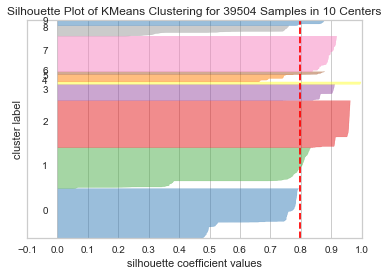

In [30]:
features4 =['Event','State']
Xevents = data[features4]

model  = KMeans(10,n_init=15)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(Xevents)
visualizer.poof()

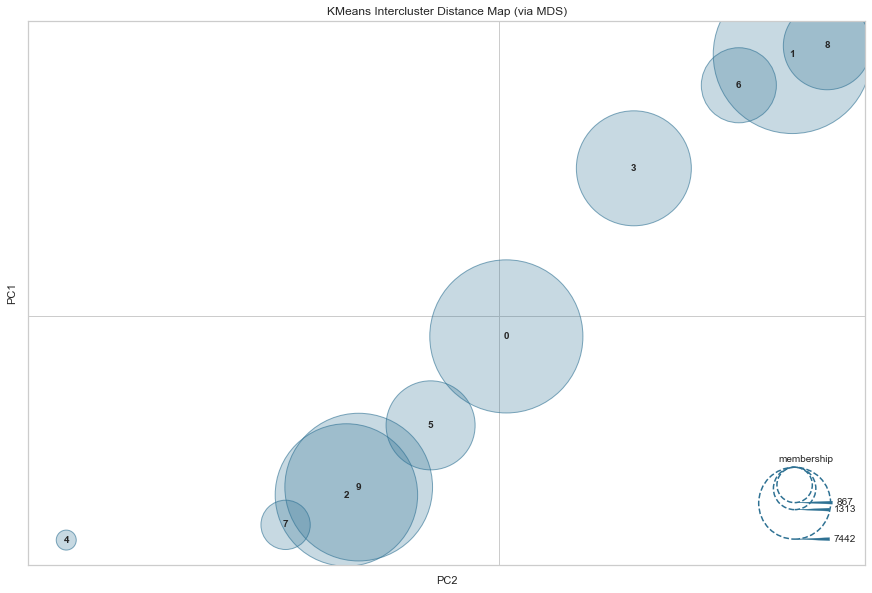

In [54]:
from yellowbrick.cluster import InterclusterDistance

visualizer = InterclusterDistance(KMeans(10),size=(1080,720),legend_loc='lower right',n_iter=15)

visualizer.fit(Xevents)
visualizer.poof()

labels = visualizer.labels_
data['clusters'] = labels

In [63]:
df = data.sort_values(by=['clusters','Event'])
df.head(20)

,UPA,EventDate,State,Primary NA,Hospitaliz,Amputation,Nature,BodyPart,Part_of _1,Event,Source,NAMELSAD,Month,Year,InsideUS,Day,clusters
352,930623,2015-01-05,35,221122,1,0,1231,511,Thigh(s),4110,562,694,1,2015,1,5,0
1205,1334270,2018-05-01,35,524126,1,0,1973,510,"Leg(s), unspecified",4110,562,173,5,2018,1,1,0
3114,1375746,2018-08-27,38,213111,1,0,111,513,Lower leg(s),4110,562,509,8,2018,1,27,0
3878,1240339,2017-07-13,0,321212,1,0,111,4420,"Finger(s), fingernail(s), unspecified",4110,562,173,7,2017,1,13,0
4157,968058,2015-03-09,9,492110,1,1,1311,539,"Foot (feet), n.e.c.",4110,9999,813,3,2015,1,9,0
5253,1316643,2018-02-14,32,713910,1,0,132,441,"Hand(s), except finger(s)",4110,562,1185,2,2018,1,14,0
9682,1223379,2017-06-05,9,238910,1,0,111,510,"Leg(s), unspecified",4110,562,761,6,2017,1,5,0
10349,1291526,2017-12-07,25,311340,0,1,1311,4422,Fingertip(s),4110,562,158,12,2017,1,7,0
10759,932424,2015-01-12,9,722513,1,0,1520,420,"Arm(s), unspecified",4110,562,694,1,2015,1,12,0
16520,1171714,2017-01-09,43,311412,1,0,132,440,"Hand(s), unspecified",4110,6629,544,1,2017,1,9,0


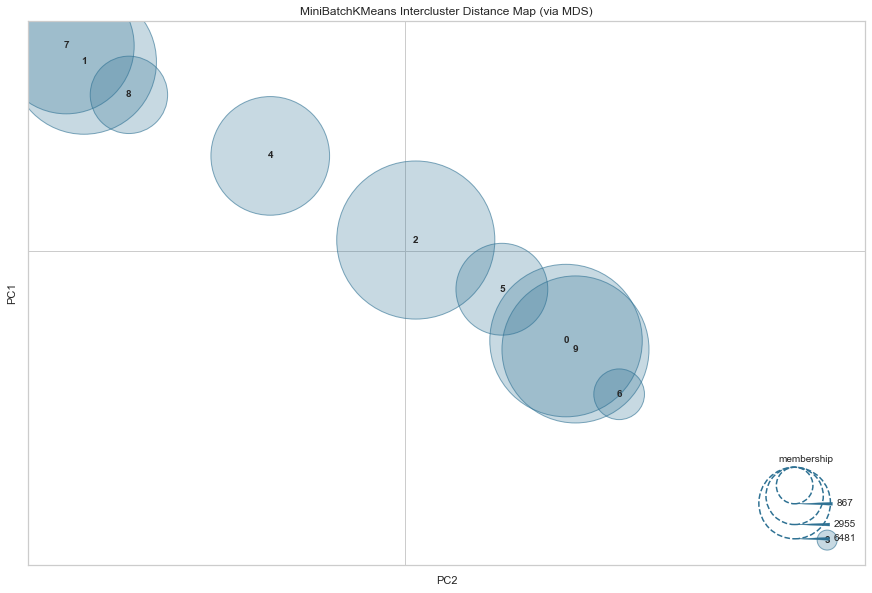

In [51]:
visualizer = InterclusterDistance(MiniBatchKMeans(10),size=(1080,720),legend_loc='lower right',n_iter=15)

visualizer.fit(Xevents)
visualizer.poof()

In [1]:
def feature_cluster_scores(data):
    estimator = KMeans(10,n_init=15)
    
    estimator.fit(data)
    silhouette = metrics.silhouette_score(data, estimator.labels_)
    
    labels = estimator.labels_
    feature['clusters'] = labels
    
    print("Silhouette Score:{}".format(silhouette))
    return feature

In [1]:
features = [X,X2,Xevents]

for feature in features:
    feature_cluster_scores(feature)

NameError: name 'X' is not defined

In [84]:
X.head()

,State,Source,BodyPart,Nature,NAMELSAD,Amputation,Month,Primary NA,Event,clusters
1,27,3714,4429,1311,332,1,6,311119,6412,0
2,27,3421,4422,1311,332,1,6,311512,6411,0
3,27,9262,6,1729,332,0,9,311512,531,0
4,27,660,52,111,698,0,1,236220,40,3
5,27,3460,510,111,698,0,1,331511,6260,0


In [85]:
X2.head()

,State,Source,BodyPart,Nature,NAMELSAD,Hospitaliz,Month,Primary NA,Event,clusters
1,27,3714,4429,1311,332,0,6,311119,6412,0
2,27,3421,4422,1311,332,0,6,311512,6411,0
3,27,9262,6,1729,332,1,9,311512,531,0
4,27,660,52,111,698,1,1,236220,40,2
5,27,3460,510,111,698,1,1,331511,6260,0
